In [8]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/trabajo-final/

# Trabajo Final: Ejercicio 1

Este ejercicio consiste en trabajar sobre la primera parte del curso para extraer un modelo geométrico de una imagen.

Para este ejercicio vamos a trabajar sobre una imagen de una cancha de Fútbol.

Se probeen las funciones `draw_lines` y `draw_lines_polar` que les pueden servir para dibujar las rectas encontradas. 

\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_utils import draw_lines, draw_lines_polar
import progressbar
import random

In [2]:
input_image = 'images/football.png'

### Load Input Image ###

In [3]:
image = cv2.imread(input_image,cv2.IMREAD_GRAYSCALE)/255

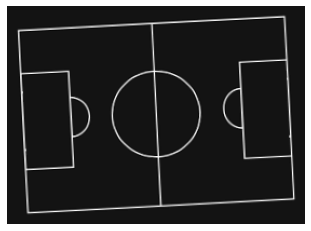

In [4]:
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.show()

In [5]:
image_bgr = cv2.imread(input_image,cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

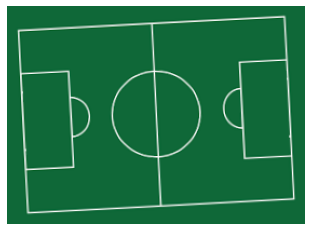

In [6]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

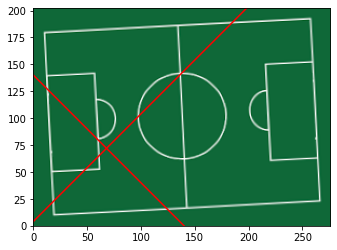

In [7]:
draw_lines(image_rgb,[[1,4],[-1,140]])

drawing rho 20 theta 120
drawing rho 100 theta 90


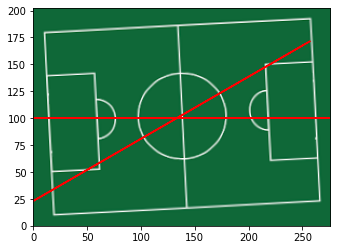

In [8]:
draw_lines_polar(image_rgb,[[20,120],[100,90]],theta_grad=True)

### Imágen de bordes ###

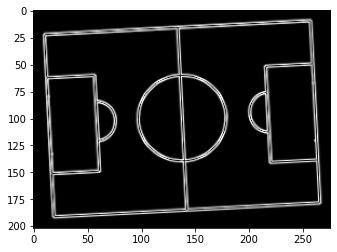

In [9]:
# Imágen a escala de grises 
img = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)/255.

# Filtro para reducir ruido



# Obtención de bordes
norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
filter_edge = np.array([-1,0,1]).reshape(1,3)
img_edge_h = cv2.filter2D(norm,-1, filter_edge.T)
img_edge_v = cv2.filter2D(norm, -1, filter_edge)

# Imágen de bordes (intensidad)
intensitity_image = np.sqrt(np.power(img_edge_h, 2) + np.power(img_edge_v,2))
plt.imshow(intensitity_image, cmap='gray', vmin=0, vmax=1)
plt.show()

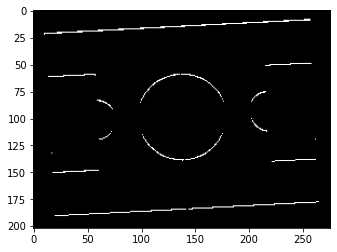

In [10]:
plt.imshow(img_edge_h, cmap='gray', vmin=0, vmax=1)
img_edge_h = img_edge_h > 0.5
plt.imshow(img_edge_h,cmap='gray', vmin=0, vmax=1)

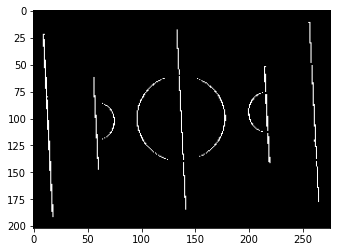

In [11]:
plt.imshow(img_edge_v, cmap='gray', vmin=0, vmax=1)
img_edge_v = img_edge_v > 0.5
plt.imshow(img_edge_v,cmap='gray', vmin=0, vmax=1)

In [15]:
def ransac_loop(image_points, points_subset, omega):
    # Estimar los parametros de la recta que pasan por points_subset
    (x1, y1) = points_subset[0]
    (x2, y2) = points_subset[1]
    inliners = 0
    """Hallar la recta que pasa por los dos puntos (pendiente-m y termino independiente-b)"""
    if x1 == x2:
        m = 0
        b = 0
    else:
        m = (y1-y2)/(x1-x2)
        b = (x1*y2 - x2*y1)/(x1-x2)
 
     # Contar cantidad de puntos de la imagen que "pasan" por la recta
    """Medimos la distancia desde todos los puntos blancos de la imagen de intensidad a la recta 
    y donde la distancia es menor a omega los consideramos como inliners """
    for (x3, y3) in image_points:
        d = np.abs(np.linalg.norm(np.cross((x2-x1, y2-y1), (x1-x3, y1-y3)))/np.linalg.norm((x2-x1, y2-y1)))
        if d <= omega:
            inliners+=1
            #print("recta: ",(m,b),", punto: ",(x3,y3),", distancia: ",d)
   
    return [m,b, inliners, (x1,y1,x2,y2)]


def ransac(image, omega, N):
    
    # Transformar los puntos de la imágen con intensidad positiva en coordenadas
    image_points = []
    width = len(image[0])
    height = len(image)
    for y in range(0, height):
        for x in range(0, width):
            if image[y][x] > 0:
                image_points.append([x,height-y])

    # Iterar ransac_loop sobre todos los subsets de puntos
    possible_lines = [] # Array de posibles rectas, falta filtrar dependiendo de sus inliners
    # Esto es una primer aproximacion pero está mal, tendria que agarrar muestras aleatorias y parar cuando se alcanza el N o se cumple algun parametro de satisfacción
    with progressbar.ProgressBar(max_value=N) as bar:
        for i in range(0, N):
            points_subset = [random.choice(image_points), random.choice(image_points)]
            line = ransac_loop(image_points, points_subset, omega)
            #print(i, " de ", N)
            bar.update(i)
            if line[2] > 150 and line not in possible_lines: # Se toman en cuenta solo las rectas que tienen x o mas inliners a manera de filtro
                #print(line)
                possible_lines.append(line)
        # Iterar sobre las lineas detectadas y filtrar dependiendo de la cantidad de inliners detectados
    possible_lines = sorted(possible_lines, key=lambda x: x[2], reverse=True)
    return possible_lines

lines_h = ransac(img_edge_h, 0.5, 200)
lines_v = ransac(img_edge_v, 0.5, 200)


100% (200 of 200) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (200 of 200) |######################| Elapsed Time: 0:00:19 Time:  0:00:19


### Non Max Suppression

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


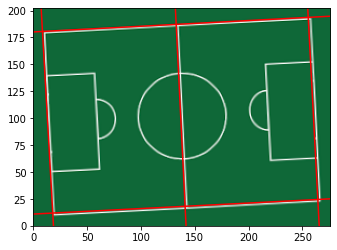

In [16]:
def lines_non_max_suppression (possible_lines):
    lines = [None, None, None, None, None]
    for line in possible_lines:
        if line[0] < 0 and line[1] < 500 and lines[0] is None:
            lines[0] = line
        elif line[0] < 0 and line[1] > 1000 and line[1] < 4000 and lines[1] is None:
            lines[1] = line
        elif line[0] < 0 and line[1] > 4000 and lines[2] is None:
            lines[2] = line
        elif line[0] > 0 and line[1] < 100 and lines[3] is None:
            lines[3] = line
        elif line[0] > 0 and line[1] > 100 and lines[4] is None:
            lines[4] = line
    return lines

lines = lines_non_max_suppression(np.concatenate((lines_h,lines_v)))


draw_lines(image_rgb,lines[:5])


### Puntos de intersección

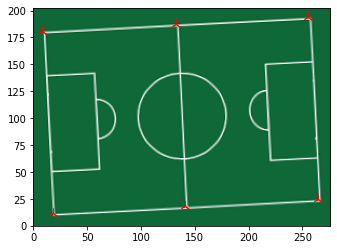

[array([   945.30769231, -16369.76923077]),
 array([  3536.5, -62147.5]),
 array([18.04775687, 11.82296189]),
 array([  8.4975707 , 180.54291765]),
 array([   945.30769231, -16369.76923077]),
 array([-1567.36363636, 34825.90909091]),
 array([140.99372352,  18.12788326]),
 array([132.69947725, 187.12315111]),
 array([  3536.5, -62147.5]),
 array([-1567.36363636, 34825.90909091]),
 array([264.29205922,  24.45087483]),
 array([255.38825165, 193.62321863]),
 array([18.04775687, 11.82296189]),
 array([140.99372352,  18.12788326]),
 array([264.29205922,  24.45087483]),
 array([-99639.1,  -5098.8]),
 array([  8.4975707 , 180.54291765]),
 array([132.69947725, 187.12315111]),
 array([255.38825165, 193.62321863]),
 array([-99639.1,  -5098.8])]

In [17]:
def lines_intersection(line1, line2):
    # https://stackoverflow.com/questions/44631259/line-line-intersection-in-python-with-numpy
    xa0, ya0, xa1, ya1 = line1[3]
    xb0, yb0, xb1, yb1 = line2[3]

    A = np.array([[xa0, ya0], [xa1, ya1]])
    B = np.array([[xb0, yb0], [xb1, yb1]])

    t, s = np.linalg.solve(np.array([A[1]-A[0], B[0]-B[1]]).T, B[0]-A[0])
    return((1-t)*A[0] + t*A[1])
   

def draw_intersections(lines):
    intersection_points = []
    for i in range(0,len(lines)):
        for j in range(0, len(lines)):  
            if i != j:
                intersection_points.append(lines_intersection(lines[i], lines[j]))
    draw_points(image_rgb, intersection_points)
    return intersection_points

def draw_points(image,points):
    fig, ax = plt.subplots()
    ax.imshow(image,  extent=[0, img.shape[1], 0, img.shape[0]])
    for x, y in points:
        ax.plot(x, y, marker='2', markersize=10, mec='r')
    ax.set_xlim(0,image.shape[1])
    ax.set_ylim(0,image.shape[0])
    plt.show()   


draw_intersections(lines)